# Mossley Hill Church: Geographic Data Science Internship

In [1]:
import pandas as pd 
import matplotlib.pyplot as plt
import geopandas as gpd
import geoplot
import os.path
import osmnx as ox
import networkx as nx
import requests
import json

import zipfile
import io

In [2]:
church_postcode = 'L18 8DB'
church_coords = (53.376628, -2.920006)

In [3]:
one_mile = 1609 #meters
immediate_neighbourhood = ox.graph_from_point(church_coords, distance=1*one_mile, network_type='drive')

In [4]:
def get_postcode_coords(postcodes):
    postcode_data = {}
    for postcode in postcodes:
        url = 'https://api.postcodes.io/postcodes/'
        postcode_data[postcode] = json.loads(requests.get(url+'/'+postcode).text)
    coords = {}
    for postcode in postcodes:
        try:
            coords[postcode] = postcode_data[postcode]['result']['latitude'], postcode_data[postcode]['result']['longitude']
        except:
            coords[postcode] = 'not found'
    return coords

## The Congregation

In [5]:
electoral_roll = pd.read_csv(os.path.join('data','electoral-roll.csv'))

In [6]:
len(electoral_roll)

242

There are 242 people on the church electoral roll.

In [7]:
ages = pd.read_excel(os.path.join('data','mossley-hill-numbers.xlsx'), sheet_name='Regulars', index_col=1)

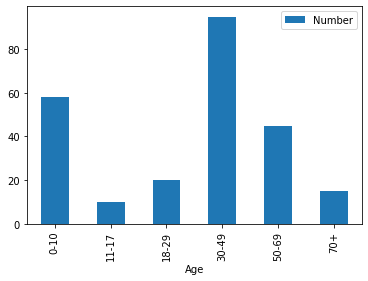

In [8]:
ages[0:6].plot.bar()

In [9]:
electoral_roll.Sex.value_counts()

f    158
m     84
Name: Sex, dtype: int64

There are almost twice as many women as men.

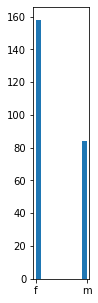

In [10]:
electoral_roll.Sex.hist(grid=False, figsize=(1,5))

In [11]:
postcodes = list(electoral_roll.Postcode.unique())

In [12]:
len(postcodes)

149

There are 149 unique postcodes. Families (within a household) must share a postcode, though not everyone who shares a postcode is necessarily in the same household. If we assume that everyone sharing a postcode is part of the same household, then there might be 18 families with a couple and one or more children.

In [13]:
electoral_roll.Postcode.value_counts()[0:20]

L17 0DH    6
L19 9DB    6
L18 4QG    5
L18 5HY    5
L18 4PP    4
L18 4QH    4
L19 9DA    4
L19 3PL    3
L18 2DY    3
L18 4RJ    3
L19 7NF    3
L19 7NN    3
L18 5EL    3
L17 0DG    3
L18 4QW    3
L18 4PZ    3
L18 5ET    3
L18 4PR    3
L18 8AL    2
L18 4QF    2
Name: Postcode, dtype: int64

In [14]:
coords = get_postcode_coords(postcodes)

In [15]:
one_mile = 1609 #meters

In [16]:
# G = ox.graph_from_point(church_coords, distance=10*one_mile, network_type='drive')
# # fig, ax = ox.plot_graph(G, fig_height=20, node_size=0)

# # save graph to disk as shapefile (for GIS) or graphml file (for gephi etc)
# ox.save_graph_shapefile(G, filename='mynetwork_shapefile')
# ox.save_graphml(G, filename='mynetwork.graphml')

In [17]:
G = ox.load_graphml('mynetwork.graphml')

In [18]:
dest_node = ox.get_nearest_node(G, church_coords)
shortest_path = {}
distance = {}
for postcode in postcodes:
    
    try:
        orig_node = ox.get_nearest_node(G, coords[postcode])
        shortest_path[postcode] = nx.shortest_path(G, orig_node, dest_node, weight='length')
        # how long is our route in meters?
        distance[postcode] = nx.shortest_path_length(G, orig_node, dest_node, weight='length') / one_mile
    except:
        pass

In [19]:
all_routes = []
for postcode in postcodes:
    try:
        all_routes.append(shortest_path[postcode])
    except:
        pass

In [20]:
nearby = {}
nearby_postcodes = []
nearby_routes = []
for postcode in postcodes:
    try:
        if distance[postcode] < 1:
            nearby_postcodes.append(postcode)
            nearby_routes.append(shortest_path[postcode])
    except:
        pass

In [21]:
len(nearby_postcodes)

83

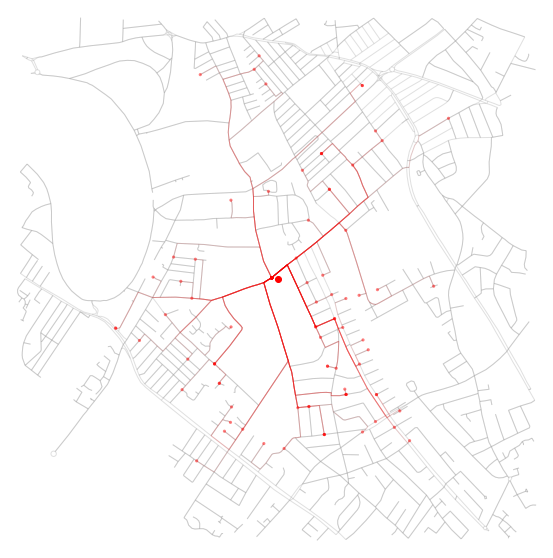

In [22]:
fig, ax = ox.plot_graph_routes(immediate_neighbourhood, nearby_routes, fig_height=10, node_size=0, orig_dest_node_size=10, edge_alpha=0.3, route_alpha=0.1, route_linewidth=1, show=False, close=False)
# for p in church_postcodes:
#     c = other_church_coords[p]
#     ax.scatter(c[1],c[0],c = 'blue')
ax.scatter(church_coords[1], church_coords[0], c='red')
plt.show()

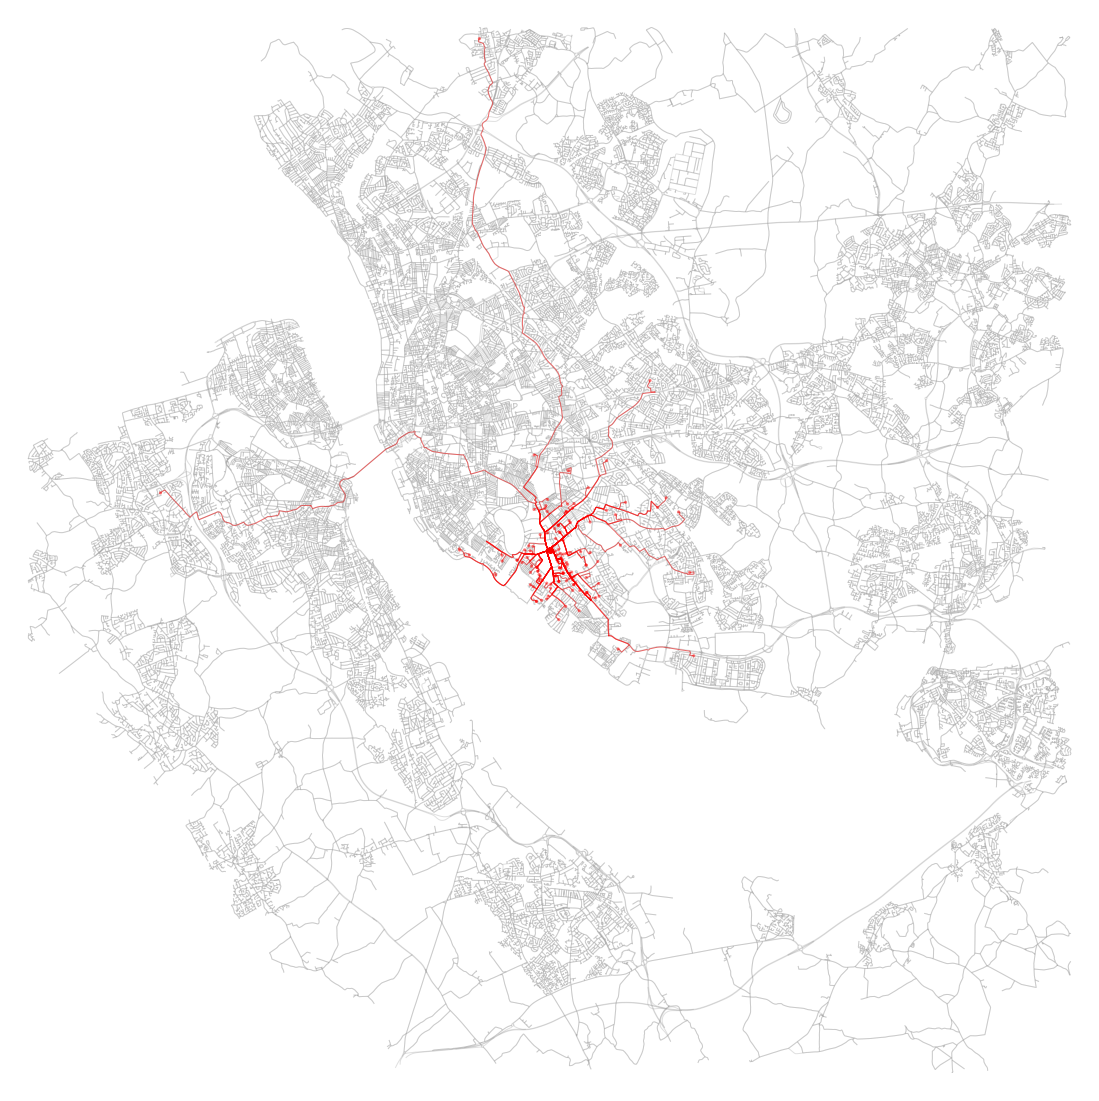

In [23]:
# plot the routes https://osmnx.readthedocs.io/en/stable/osmnx.html#module-osmnx.plot
fig, ax = ox.plot_graph_routes(G2, all_routes, fig_height=20, node_size=0, orig_dest_node_size=10, edge_alpha=0.3, route_linewidth=1, show=False, close=False)
# for p in church_postcodes:
#     c = other_church_coords[p]
#     ax.scatter(c[1],c[0],c = 'blue')
ax.scatter(church_coords[1], church_coords[0], c='red')
plt.show()

In [26]:
dist = pd.DataFrame(distance, index=['Distance']).transpose()

electoral_roll.set_index('Postcode', inplace=True)

electoral_roll.insert(loc=1,column='Distance',value=dist.Distance)

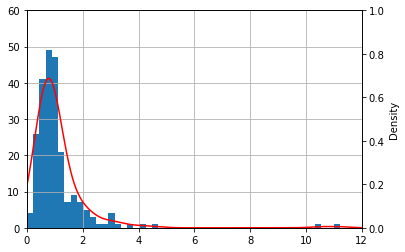

In [44]:
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.set_ylim(0,60)
ax2.set_ylim(0,1)
ax.set_xlim(0,12)
electoral_roll.Distance.hist(bins=50, ax=ax)
electoral_roll.Distance.plot.kde(ax=ax2, c = 'r')

In [29]:
electoral_roll.Distance.describe()

count    231.000000
mean       1.096536
std        1.141151
min        0.000000
25%        0.618399
50%        0.881692
75%        1.156037
max       11.215157
Name: Distance, dtype: float64

In [30]:
print('Furthest')
electoral_roll.sort_values('Distance', ascending=False)[0:20].transpose()

Furthest


Postcode,L31 8DW,CH49 4PD,L14 9QB,L24 3Th,L25 9NT,L25 2QH,L25 2RR,L25 2RR,L19 2RR,L19 2RR,L25 4SB,L17 7EP,L17 7HP,L16 6AY,L16 6AY,L15 8GB,L15 8GB,L15 4NB,L15 4NB,L16 0JF
Sex,f,f,f,f,m,m,f,m,f,m,f,m,f,f,m,f,m,m,f,m
Distance,11.2152,10.4956,4.56746,4.0782,3.75342,3.29262,3.13809,3.13809,2.97795,2.97795,2.883,2.47024,2.38098,2.3131,2.3131,2.2392,2.2392,2.22372,2.22372,2.02856


In [31]:
print('Nearest')
electoral_roll.sort_values('Distance',)[0:20].transpose()

Nearest


Postcode,L18 8DB,L18 8DB,L18 4QB,L18 4QE,L18 4QF,L18 4QF,L17 0DH,L17 0DH,L17 0DH,L17 0DH,L17 0DH,L17 0DH,L18 8AJ,L18 8AJ,L18 4PH,L18 4PZ,L18 4PZ,L18 4PZ,L18 4PH,L18 4RE
Sex,f,f,f,f,m,f,f,f,m,f,f,f,f,m,f,f,f,m,m,f
Distance,0,0,0.120456,0.215217,0.295958,0.295958,0.32228,0.32228,0.32228,0.32228,0.32228,0.32228,0.337607,0.337607,0.33818,0.33818,0.33818,0.33818,0.33818,0.360885


In [32]:
electoral_roll.loc[electoral_roll.Distance.isnull()].transpose()

Postcode,L18 4AU,L17 0RQ,L18 4 RN,L17 6OA,Merseyside,L17 3PG,L18 3DS,L17 6OH,Merseyside,Liverpool,l17
Sex,f,m,f,m,f,m,m,m,f,m,m
Distance,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## The Parish

[Mossley Hill Church](https://mossleyhillchurch.org.uk/who-we-are/), Rose Lane, Liverpool L18 8DB.

>The Church of St Matthew and St James stands at the top of the hill in Rose Lane, Mossley Hill, Liverpool. It is an active Anglican parish church in the deanery of Liverpool South Childwall, the archdeaconry of Liverpool and the diocese of Liverpool. The church is recorded in the National Heritage List for England as a designated Grade II* listed building. The authors of the Buildings of England series describe it as "one of the best Victorian churches in Liverpool"

In [34]:
churches = pd.read_csv(os.path.join('data','other-churches.csv'))

In [35]:
church_postcodes = list(churches.Postcode)

In [36]:
other_church_coords = get_postcode_coords(church_postcodes)

In [37]:
churchlist = ''
for church in churches.Church:
    churchlist += church + '; '

print(f'**Nearby Churches**: {churchlist[:-2]}')

**Nearby Churches**: Allerton URC; All Souls; All Hallows; Carmelite Monastery; Garston Park Church; Long Lane Church; St Mary's Grassendale; Mossley Hill Church; St Francis of Assissi Church; St Barnabas Penny Lane; Aigburth Community Church; St Peter's Church; Liverpool Roman Catholic Archdiocesan Trust; St Anthony's Friary; Our Lady of the Annuniciation - Bishop Eton; St James' Church; Elm Hall Drive Methodist Church; Liverpool District Methodist Church; Cornerstone Church Liverpool; Farnworth Church; Catholic Church of St Thomas More; Wavertree Christian Fellowship; St Anne's Aigburth; St Mary's Church, Woolton; St Hilda's Church; Hamlet Baptist Church; Christ Church, Toxteth Park; Gateway Church; St Charles R.C. Church; St Columba URC Church; Grace Family Church; St Michael's Hamlet; St Anthony of Padua RC Church; Holy Family Catholic Church; Saint Charles Borromeo R.C. Church; Parish of St John Vianney; Jubilee Church Liverpool


In [38]:
churches.transpose()

,0,1,2,3,4,5,6,7,8,9,...,27,28,29,30,31,32,33,34,35,36
Church,Allerton URC,All Souls,All Hallows,Carmelite Monastery,Garston Park Church,Long Lane Church,St Mary's Grassendale,Mossley Hill Church,St Francis of Assissi Church,St Barnabas Penny Lane,...,Gateway Church,St Charles R.C. Church,St Columba URC Church,Grace Family Church,St Michael's Hamlet,St Anthony of Padua RC Church,Holy Family Catholic Church,Saint Charles Borromeo R.C. Church,Parish of St John Vianney,Jubilee Church Liverpool
Postcode,L18 7HD,L19 4TF,L18 6JJ,L18 3NU,L19 9AF,L19 6PF,L19 2LD,L18 8DB,L19 1RT,L18 1LZ,...,L24 9HJ,L17 9PG,L25 0NR,L17 9PE,L17 7BB,L18 8AY,L25 8TG,L17 9PG,L26 0UG,L17 3AL


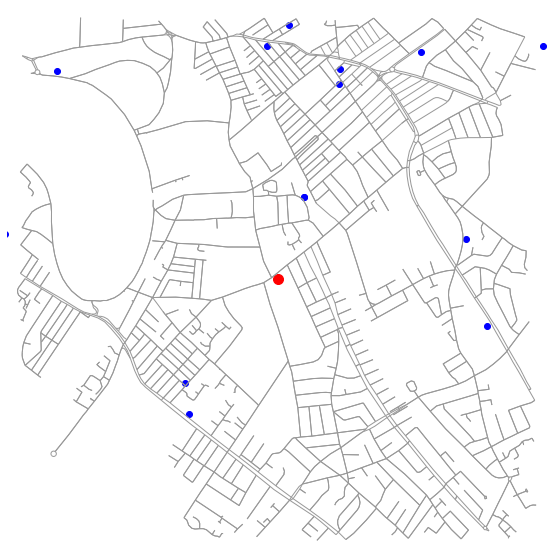

In [39]:
fig, ax = ox.plot_graph(immediate_neighbourhood, fig_height=10, node_size=0, show=False, close=False)
for p in church_postcodes:
    c = other_church_coords[p]
    ax.scatter(c[1],c[0],c = 'blue')
ax.scatter(church_coords[1], church_coords[0], c='red', s=100)
plt.show()

In [40]:
def get_street_names(coords, miles):
    neighbourhood_graph = ox.project_graph(ox.graph_from_point(coords, distance=miles*one_mile, network_type='drive'))
    ints = ox.clean_intersections(neighbourhood_graph)

    gdf = gpd.GeoDataFrame(ints, columns=['geometry'], crs=neighbourhood_graph.graph['crs'])
    X = gdf['geometry'].map(lambda pt: pt.coords[0][0])
    Y = gdf['geometry'].map(lambda pt: pt.coords[0][1])

    nodes = ox.get_nearest_nodes(neighbourhood_graph, X, Y, method='kdtree')
    nearby_streets = {'Rose Lane'}
    for n in nodes:
        for nbr in nx.neighbors(neighbourhood_graph, n):
            for d in neighbourhood_graph.get_edge_data(n, nbr).values():
                if 'name' in d:
                    if type(d['name']) == str:
                        nearby_streets.add(d['name'])
                    elif type(d['name']) == list:
                        for name in d['name']:
                            nearby_streets.add(name)
                    else:
                        pass
                else:
                    pass

    return nearby_streets

In [41]:
miles = 0.5
nearby_streets = get_street_names(church_coords, miles)
print(f'There are {len(nearby_streets)} streets within {miles} miles of the church.')
print(nearby_streets)

There are 109 streets within 0.5 miles of the church.
{'Mossville Road', 'Drewell Road', 'Ribbledale Road', 'Milner Road', 'Lyttelton Road', 'Hillview', 'Mather Avenue', 'Brodie Avenue', 'Rosemont Road', 'Mentmore Road', 'Ashlar Road', 'Ashlar Grove', 'Queens Drive', 'Pitville Road', 'Hollywood Road', 'Pitville Avenue', 'Briardale Road', 'Dovedale Road', 'Donalds Way', 'Rathmore Avenue', 'Carnatic Road', 'Park Avenue', 'North Sudley Road', 'Cromer Road', 'Elmar Road', 'Craigmore Road', 'Rose Lane', 'Lochmore Road', 'Kylemore Avenue', 'Reedale Close', 'Ardmore Road', 'Pitville Close', 'Rimmington Road', 'Garthdale Road', 'Glenmore Avenue', 'Reedale Road', 'Molyneux Road', 'Rose Terrace', 'Erylmore Road', 'Martin Close', 'Mossley Hill Road', 'Gladeville Road', 'Hartdale Road', 'Bridge Road', 'Elmsley Road', 'Tullimore Road', 'Boxmoor Road', 'Kelton Grove', 'Lugard Road', 'Arranmore Road', 'Cyril Grove', 'Barkhill Road', 'Purley Grove', 'Martin Road', 'Dundonald Road', 'Wingate Road', 'Su

## Liverpool Neighbourhoods

In [ ]:
# get neighbourhood data

In [64]:
oac2011 = pd.read_csv(os.path.join('data','2011 OAC Clusters and Names csv v2.csv'))

In [72]:
oac2011['Region/Country Name'].unique()

array(['London', 'North West', 'Yorkshire and The Humber', 'North East',
       'West Midlands', 'East Midlands', 'South West', 'East',
       'South East', 'Northern Ireland', 'Scotland', 'Wales'],
      dtype=object)

In [64]:
northwest = oac2011.loc[oac2011['Region/Country Name']=='North West']

northwest.rename(columns={'Output Area Code':'OA11CD'}, inplace=True)

In [92]:
northwest['Local Authority Name'].unique()

array(['Bolton', 'Bury', 'Manchester', 'Oldham', 'Rochdale', 'Salford',
       'Stockport', 'Tameside', 'Trafford', 'Wigan', 'Knowsley',
       'Liverpool', 'St. Helens', 'Sefton', 'Wirral', 'Halton',
       'Warrington', 'Blackburn with Darwen', 'Blackpool',
       'Cheshire West and Chester', 'Cheshire East', 'Allerdale',
       'Barrow-in-Furness', 'Carlisle', 'Copeland', 'Eden',
       'South Lakeland', 'Burnley', 'Chorley', 'Fylde', 'Hyndburn',
       'Lancaster', 'Pendle', 'Preston', 'Ribble Valley', 'Rossendale',
       'South Ribble', 'West Lancashire', 'Wyre'], dtype=object)

In [154]:
liverpool = northwest.loc[northwest['Local Authority Name']=='Liverpool']

In [65]:
# shape_url = 'https://opendata.arcgis.com/datasets/ff8151d927974f349de240e7c8f6c140_0.zip'

# shape_data = gpd.read_file(shape_url)
# shape_data.plot()

In [87]:
liverpool_shapes = shape_data.merge(liverpool, on='OA11CD')
liverpool_shapes.to_file(os.path.join('data','liverpool.shp'))

In [90]:
liverpool_from_file = gpd.read_file(os.path.join('data','liverpool.shp'))

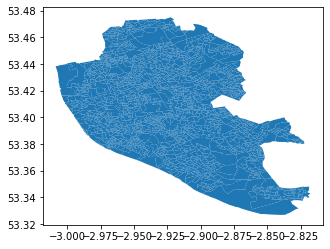

In [91]:
liverpool_from_file.plot()

In [74]:
nw_shapes['Supergroup Code'].unique()

array([5, 6, 8, 7, 4, 1, 2, 3], dtype=int64)

In [139]:
supergroups = list(oac2011['Supergroup Name'].unique())
supergroups

['Cosmopolitans',
 'Ethnicity Central',
 'Multicultural Metropolitans',
 'Hard-Pressed Living',
 'Constrained City Dwellers',
 'Urbanites',
 'Suburbanites',
 'Rural Residents']

C:\ProgramData\Miniconda3\lib\site-packages\geopandas\plotting.py:532: UserWarning: The GeoDataFrame you are attempting to plot is empty. Nothing has been displayed.
  UserWarning,


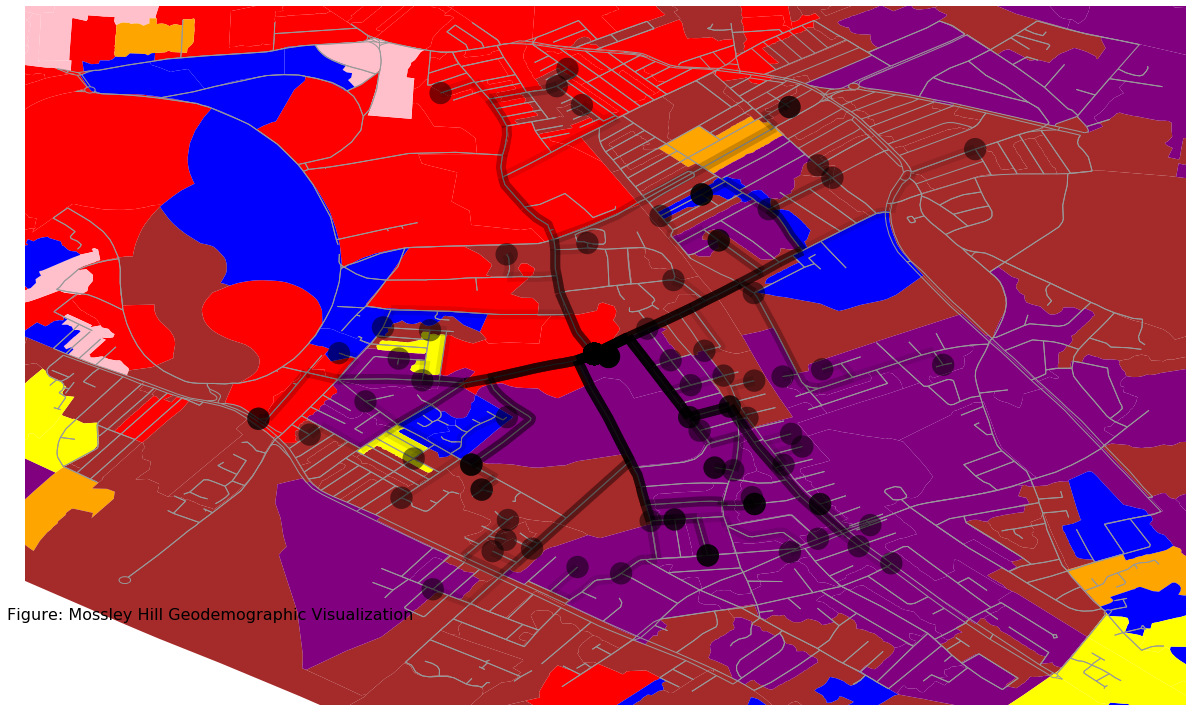

In [164]:
clusters = range(8)

# https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.plot.plot_graph_routes
fig, ax = ox.plot_graph_routes(immediate_neighbourhood, nearby_routes, fig_height=10, node_size=0, orig_dest_node_size=500, orig_dest_node_color='k',edge_alpha=1, route_alpha=.1, route_color='k', route_linewidth=10, show=False, close=False)

nw_clusters = {}
for c in clusters:
    nw_clusters[c] = liverpool_shapes[liverpool_shapes['Supergroup Code']==c+1]

# these colours are ugly, but I can change them later
# i've tried to make them match the standard https://maps.cdrc.ac.uk/#/geodemographics/oac11/, 
cluster_colors = ['green', 'red', 'pink', 'orange', 'brown', 'purple', 'blue',  'yellow']

for c in clusters:
    nw_clusters[c].plot(color=cluster_colors[c], ax=ax)
    ax.set_facecolor('#e0f8f8')
    ax.get_xaxis().set_ticks([])
    ax.get_yaxis().set_ticks([])

fig.suptitle('Figure: Mossley Hill Geodemographic Visualization',
            fontsize=16,
            y=0.15, x = 0.17)
fig.tight_layout()
ax.scatter(church_coords[1], church_coords[0], c='black', s=500)

plt.show()

In [110]:
convert_url = 'https://www.arcgis.com/sharing/rest/content/items/ef72efd6adf64b11a2228f7b3e95deea/data'
r = requests.get(convert_url)
z = zipfile.ZipFile(io.BytesIO(r.content))
filename = 'PCD11_OA11_LSOA11_MSOA11_LAD11_EW_LU_aligned_v2.csv'
conversion_chart = pd.read_csv(z.open(filename))

C:\ProgramData\Miniconda3\lib\site-packages\IPython\core\interactiveshell.py:3063: DtypeWarning: Columns (9) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [112]:
conversion_chart.set_index('PCD7', inplace=True)

In [128]:
lp_pc2oa = conversion_chart[['OA11CD']].loc[conversion_chart['LAD11NM']=='Liverpool']

In [130]:
conversion_dict = lp_pc2oa.transpose().to_dict()

In [157]:
liverpool.set_index('OA11CD',inplace=True)

In [158]:
oac_dict = liverpool[['Supergroup Name']].transpose().to_dict()

In [166]:
nbhd = {}
for p in postcodes:
    try:
        n = oac_dict[conversion_dict[p]['OA11CD']]['Supergroup Name']
    except:
        n = 'unknown'
    nbhd[p] = n

In [169]:
nbhd_df = pd.DataFrame(nbhd, index=['Type']).transpose()
electoral_roll.insert(loc=1,column='Neighbourhood Type',value=nbhd_df.Type)

In [173]:
electoral_roll['Neighbourhood Type'].value_counts()

Suburbanites                   124
Urbanites                       64
unknown                         28
Cosmopolitans                   10
Hard-Pressed Living              6
Constrained City Dwellers        6
Multicultural Metropolitans      4
Name: Neighbourhood Type, dtype: int64

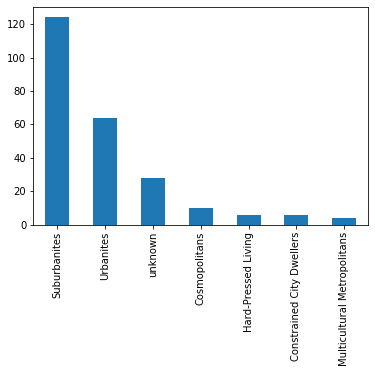

In [179]:
electoral_roll['Neighbourhood Type'].value_counts().plot.bar()

> **Suburbanites** The population of this supergroup is most likely to be located on the outskirts of urban areas. They
are more likely to own their own home and to live in semi-detached or detached properties. The
population tends to be a mixture of those above retirement age and middle-aged parents with
school age children. The number of residents who are married or in civil-partnerships is above the
national average. Individuals are likely to have higher-level qualifications than the national average,
with the levels of unemployment in these areas being below the national average. All non-White
ethnic groups have a lower representation when compared with the UK and the proportion of
people born in the UK or Ireland is slightly higher. People are more likely to work in the information
and communication, financial, public administration, and education sectors, and use private
transport to get to work. [OAC2011 Pen Portraits](https://www.ons.gov.uk/file?uri=/methodology/geography/geographicalproducts/areaclassifications/2011areaclassifications/penportraitsandradialplots/penportraits.pdf)

## Other Neighbourhood Data

In [45]:
# annual age/population estimates
age_url = 'https://www.ons.gov.uk/file?uri=%2fpeoplepopulationandcommunity%2fpopulationandmigration%2fpopulationestimates%2fdatasets%2fcensusoutputareaestimatesinthenorthwestregionofengland%2fmid2018sape21dt10b/sape21dt10bmid2018northwest.zip'
r = requests.get(age_url)
r.content
z = zipfile.ZipFile(io.BytesIO(r.content))
filename = 'SAPE21DT10b-mid-2018-coa-unformatted-syoa-estimates-north-west.xlsx'
age_data = pd.read_excel(z.open(filename), sheet_name = 'Mid-2018 Persons')
male_age_data = pd.read_excel(z.open(filename), sheet_name = 'Mid-2018 Males')
female_age_data = pd.read_excel(z.open(filename), sheet_name = 'Mid-2018 Females')

In [ ]:
# deprivation
# https://www.gov.uk/government/statistics/english-indices-of-deprivation-2019

In [ ]:
# schools
## https://www.compare-school-performance.service.gov.uk/download-data

In [ ]:
# house prices
## https://www.ons.gov.uk/peoplepopulationandcommunity/housing/datasets/medianpricepaidbylowerlayersuperoutputareahpssadataset46

In [ ]:
# income
## https://www.ons.gov.uk/employmentandlabourmarket/peopleinwork/earningsandworkinghours/datasets/smallareaincomeestimatesformiddlelayersuperoutputareasenglandandwales

In [ ]:
# 2011 census data
## https://www.nomisweb.co.uk/census/2011/bulk/r2_2